In [2]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

## Import and parse Iris training dataset

In [5]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/kaimo/.keras/datasets/iris_training.csv


In [6]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [7]:
BATCH_SIZE = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern=train_dataset_fp,
    batch_size=BATCH_SIZE,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

In [17]:
# Note that we need to pack the features together
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=-1)
    return features, labels

In [18]:
train_dataset = train_dataset.map(pack_features_vector)

## Create model use Keras

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

## Train model

In [21]:
# loss object
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# optimizer
optimizer = tf.keras.optimizers.SGD(0.01)

## Training loop

In [23]:
train_loss_list = []
train_acc_list = []
NUM_EPOCHS = 201

for epoch in range(NUM_EPOCHS):
    epoch_loss_mean = tf.keras.metrics.Mean()
    epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    for x, y in train_dataset:
        with tf.GradientTape() as tape:
            pred = model(x, training=True)
            loss = loss_obj(y, pred)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_mean.update_state(loss)
        epoch_acc.update_state(y, pred)
        
    # End epoch
    train_loss_list.append(epoch_loss_mean.result())
    train_acc_list.append(epoch_acc.result())
    
    if epoch % 50 == 0:
        print('Epoch {:3d}: Loss: {:.3f}, Accuracy: {:.3%}'.format(epoch, epoch_loss_mean.result(), epoch_acc.result()))

Epoch   0: Loss: 1.167, Accuracy: 42.500%
Epoch  50: Loss: 0.336, Accuracy: 90.833%
Epoch 100: Loss: 0.243, Accuracy: 95.833%
Epoch 150: Loss: 0.179, Accuracy: 97.500%
Epoch 200: Loss: 0.141, Accuracy: 97.500%


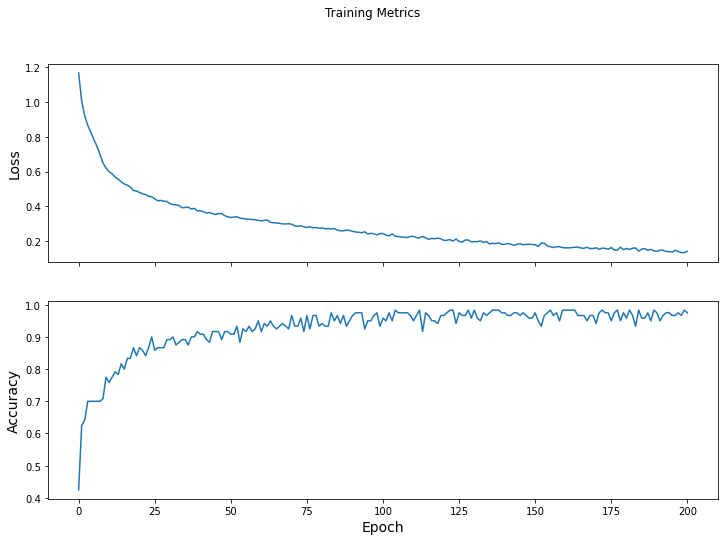

In [25]:
# Visualize the loss function over time
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_list)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_acc_list)
plt.show()

## Evaluate model

In [26]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [28]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    BATCH_SIZE,
    column_names,
    label_name=label_name,
    num_epochs=1,
    shuffle=False
)
test_dataset = test_dataset.map(pack_features_vector)

In [29]:
test_acc = tf.keras.metrics.Accuracy()

for x, y in test_dataset:
    logits = model(x, training=False)
    pred = tf.argmax(logits, axis=-1, output_type=tf.int32)
    test_acc(y, pred)
    
print('Test accuracy: {:.2%}'.format(test_acc.result()))

Test accuracy: 96.67%


## Make predictions

In [43]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
pred = model(predict_dataset, training=False)

for idx, logits in enumerate(pred):
    class_idx = tf.argmax(logits, axis=-1, output_type=tf.int32)
    prob = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print('Example {} prediction: {} ({:.1%})'.format(idx, name, prob))

Example 0 prediction: Iris setosa (98.8%)
Example 1 prediction: Iris versicolor (92.1%)
Example 2 prediction: Iris virginica (72.9%)
